In [7]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="bright",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 1
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"


data = {
    # "CPR and Schur only": load_data('../1/thermal_dynamic', n_newest=NUM_SIMS),
    # "Many solvers": load_data("thermal_many_solvers", n_newest=NUM_SIMS),
    "Many solvers gp": load_data("thermal_many_solvers_gp", n_newest=NUM_SIMS),
}

save_media_path = Path("media")
save_media_path.mkdir(exist_ok=True)

Loading data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_1.npy


Many solvers gp 512.4267728328705 0.0


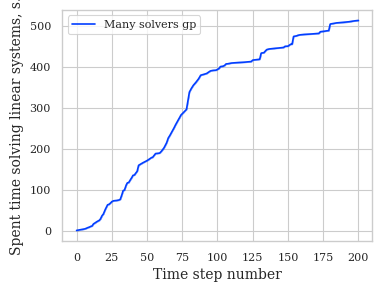

In [8]:
color_iter = -1
best_time = float("inf")
plt.figure(figsize=(4, 3))
for name, values in data.items():
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if USE_SIMULATED_TIME:
        assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

Many solvers gp


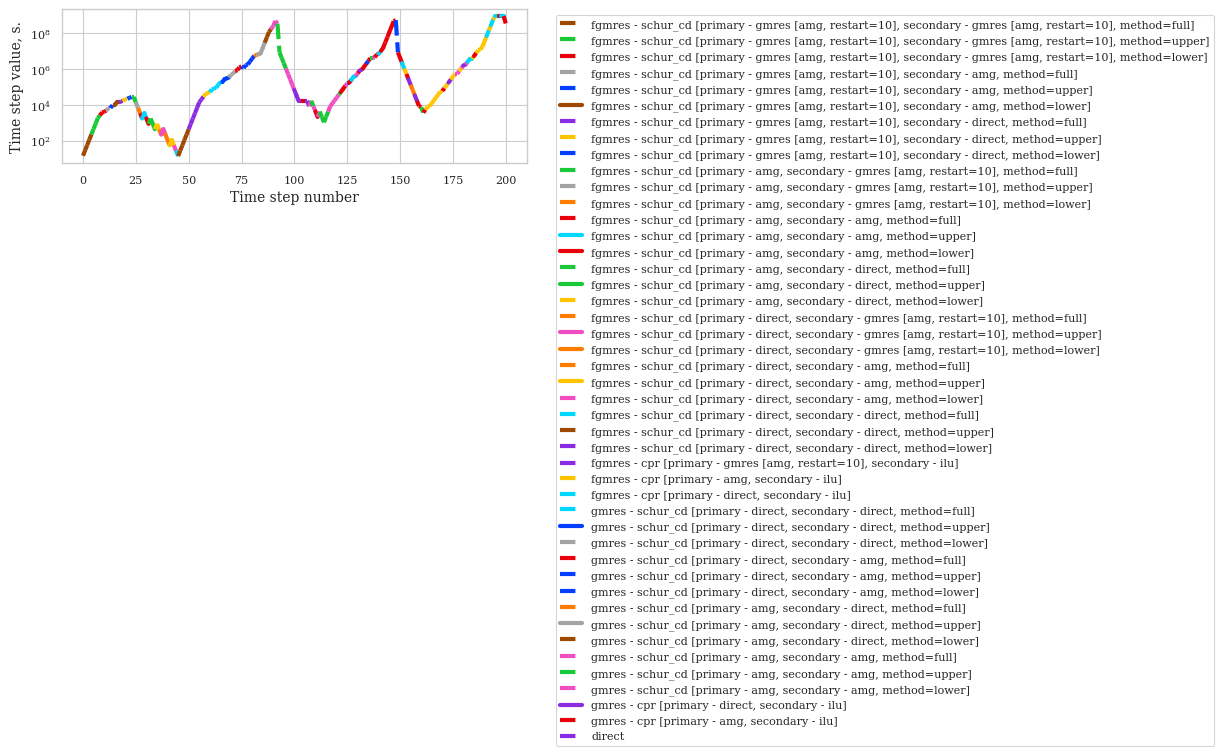

0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
2 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
3 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
4 gmres - cpr [primary - direct, secondary - ilu]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
6 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
7 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
8 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
9 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
10 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
11 gmres - schur_cd [primary - amg, secondary - direct, method=full]
12 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
13 gmres - cpr [primary - amg, secondary - ilu]
14 fgmres -

In [6]:
def make_solver_colors(data: Sequence[SolverSelectionData]):
    def make_hashable(x: SolverSelectionData):
        return tuple(x.prediction.decision.subsolvers.items())

    from thermal_solvers import make_thermal_solver_space

    solver_space = make_thermal_solver_space("full")
    all_solvers = solver_space.get_all_solvers()

    subsolvers = list({make_hashable(x) for x in data})
    subsolvers_to_number = {subsolver: i for i, subsolver in enumerate(subsolvers)}

    solver_names = dict()
    for subsolvers, i in subsolvers_to_number.items():
        config = None
        tested = list(dict(subsolvers).values())
        for solver_template in all_solvers:
            expected = list(solver_template.subsolvers.values())
            if tested == expected:
                config = solver_space.config_from_decision(
                    solver_template.use_defaults(), optimized_only=True
                )
                break
        assert config is not None
        solver_names[i] = solver_space.format_config(config)

    return [subsolvers_to_number[make_hashable(entry)] for entry in data], solver_names


def color_solvers(x, values, colors, names):
    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(values.size)

    names = names.copy()
    for i in range(len(x)):
        x_ = x[i : i + 2]
        val = values[i : i + 2]
        color = colors[i]
        args = {}
        if color in names:
            name = names.pop(color)
            # name = color
            args["label"] = name
        if color > 9:
            args["linestyle"] = "--"
        plt.plot(x_, val, linewidth=lw, c=f"C{color}", **args)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


for name, vals in data.items():
    colors_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    for perf in vals:
        solver_colors, solver_names = make_solver_colors(perf)
        colors_list.append(solver_colors)
        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    print(name)
    # plt.figure(figsize=(6, 2))
    # color_solvers(sim_time_list[0], inlet_rate_list[0], colors_list[0], solver_names)
    # plt.ylabel("Source rate, $m^3 s^{-1}$.")
    # plt.xlabel(X_LABEL)
    # plt.yscale("log")
    # if save_media_path is not None:
    #     plt.savefig(save_media_path / f"thermal_source_{name}.pdf", bbox_inches="tight")
    # plt.show()

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel(X_LABEL)
    color_solvers(sim_time_list[0], time_step_list[0], colors_list[0], solver_names)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_dt_{name}.pdf", bbox_inches="tight")
    plt.show()
    for i, name in solver_names.items():
        print(i, name)

Can we choose 2-3 best solvers from the bigger list of solvers?
evaluate cumulative performance prediction of pairs (or n solvers) after the simulation. 

Important thing the paper provides: the methology.
The amount of exploration is fixed for one solver. If we have more solvers, we need more exploration.

In [15]:
from tqdm import tqdm
import itertools
from solver_selector.solver_selector import make_solver_selector
from thermal_solvers import make_thermal_solver_space

from thermal_solvers import DirectSolverNode, ForkNode


solver_space = make_thermal_solver_space("full")
# solver_space = ForkNode([DirectSolverNode(), DirectSolverNode(name='direct1')])
all_solvers = solver_space.get_all_solvers()
combinations_scores = {}
for comb in tqdm(list(itertools.combinations(range(len(all_solvers)), 2))):
    if comb != (6, 8):
        continue
    print(comb)
    solvers_to_use = all_solvers[comb[0]], all_solvers[comb[1]]
    solver_selector = make_solver_selector(
        solver_space,
        params={
            "exploration": 0,
            "load_statistics_paths": [
                "performance/thermal_many_solvers_gp_1.npy",
            ],
        },
        solver_templates=solvers_to_use,
    )
    for performance_predictor in solver_selector.predictors:
        assert performance_predictor.is_initialized
    scores = []
    for entry in data["Many solvers gp"][0]:
        solver = solver_selector.select_solver(entry.prediction.context)
        expected_score = solver.score
        scores.append(expected_score)
    combinations_scores[comb] = scores

  0%|          | 0/990 [00:00<?, ?it/s]

(6, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_gp_1.npy
Used 4 / 201 data points.


100%|██████████| 990/990 [00:00<00:00, 1636.78it/s]


In [21]:
from tqdm import tqdm
import itertools
from solver_selector.solver_selector import make_solver_selector
from thermal_solvers import make_thermal_solver_space

from thermal_solvers import DirectSolverNode, ForkNode


solver_space = make_thermal_solver_space("full")
# solver_space = ForkNode([DirectSolverNode(), DirectSolverNode(name='direct1')])
all_solvers = solver_space.get_all_solvers()
combinations_scores = {}

solver_selector = make_solver_selector(
    solver_space,
    params={
        "exploration": 0,
        "load_statistics_paths": [
            "performance/thermal_many_solvers_gp_1.npy",
        ],
    },
)

solver_scores = {}

for i, performance_predictor in enumerate(solver_selector.predictors):
    print(i)
    assert performance_predictor.is_initialized
    scores = []
    for entry in data['Many solvers gp'][0]:
        solver = performance_predictor.select_solver_parameters(entry.prediction.context)
        scores.append(solver.score)
    solver_scores[i] = np.array(scores)

combinations_scores = {}

for comb in itertools.combinations(range(len(all_solvers)), 2):
    s0_scores = solver_scores[comb[0]]
    s1_scores = solver_scores[comb[1]]
    combinations_scores[comb] = np.maximum(s0_scores, s1_scores)

Selecting from 45 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
2 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
3 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
4 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
6 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
7 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
8 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
9 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
10 fgmres - schur_cd [primary - amg, s

Best pairs of solvers:
0
gmres - schur_cd [primary - amg, secondary - amg, method=upper]
gmres - cpr [primary - amg, secondary - ilu]

1
fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
gmres - cpr [primary - amg, secondary - ilu]

2
gmres - schur_cd [primary - amg, secondary - amg, method=lower]
gmres - cpr [primary - amg, secondary - ilu]

3
fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
gmres - cpr [primary - amg, secondary - ilu]

4
fgmres - schur_cd [primary - amg, secondary - amg, method=full]
gmres - cpr [primary - amg, secondary - ilu]

5
fgmres - cpr [primary - amg, secondary - ilu]
gmres - cpr [primary - amg, secondary - ilu]



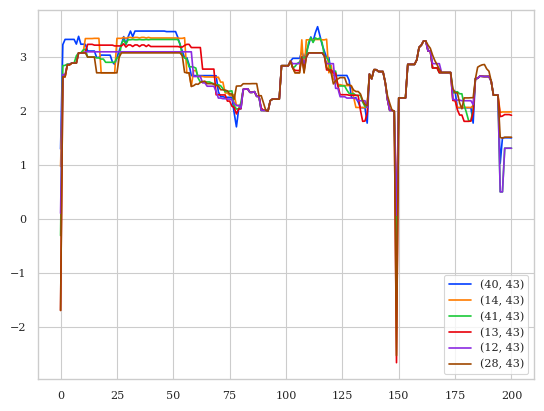

In [20]:
comb_total = {comb: sum(score) for comb, score in combinations_scores.items()}
n_best = sorted(comb_total, key=comb_total.get, reverse=True)[:6]

print("Best pairs of solvers:")
for i, comb in enumerate(n_best):
    plt.plot(combinations_scores[comb], label=comb)

    print(i)
    for id in comb:
        default = all_solvers[id].use_defaults()
        conf = solver_space.config_from_decision(decision=default, optimized_only=True)
        print(solver_space.format_config(conf))
    print()
plt.legend()

In [6]:
best_solvers_ids = list(set(item for pair in n_best for item in pair))
best_solvers = {i: all_solvers[i] for i in best_solvers_ids}

In [7]:
for i, sol in best_solvers.items():
    default = sol.use_defaults()
    conf = solver_space.config_from_decision(decision=default, optimized_only=True)
    print(i, solver_space.format_config(conf))

9 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
10 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
11 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
13 fgmres - cpr [primary - amg, secondary - ilu]
14 gmres - schur_cd [primary - amg, secondary - amg, method=full]
16 gmres - schur_cd [primary - amg, secondary - amg, method=lower]


I've got some promising results with experiment 4. I ran (only once) the thermal experiment with many possible solvers and it the framework mostly explored. Next, I did this: For each pair of solvers, I predicted the performance for the whole simulation based on those data. Then I looked at the predictions and picked the expected best pair of solvers. The results are expected / meaningful! This means, we can put a lot of options into solver selection and prune bad options for further simulations.